In [1]:
pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 4.2 MB 67.5 MB/s 
     |████████████████████████████████| 1.2 MB 50.7 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 74.9 MB/s 
     |████████████████████████████████| 6.6 MB 64.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=25246f35b96dc4f4ce90e07e87b16a8c326e27df8cb8c9438a2d4a668a8f2a83
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from tensorflow.keras.optimizers import Adam, Adadelta
from keras.callbacks import ModelCheckpoint

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# File paths
TRAIN_CSV = '/content/drive/My Drive/NLP/QP/train.csv'
TEST_CSV = '/content/drive/My Drive/NLP/QP/test.csv'
#EMBEDDING_FILE = '/content/drive/My Drive/NLP/wiki-news-300d-1M.vec'
MODEL_SAVING_DIR = '/content/drive/My Drive/NLP/'

In [6]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
questions_cols = ['question1', 'question2']
from sentence_transformers import SentenceTransformer


In [9]:
sentences = list(train_df['question1'])
print(len(sentences))
for i in train_df['question2']:
  sentences.append(i)
print(len(sentences))

model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
embeddings = model.encode(sentences)
type(embeddings)

404290
808580


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

numpy.ndarray

In [10]:


# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops :
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])
                    # Replace questions as word to question as number representation
            #dataset.set_value(index, question, q2n)
            dataset.at[index, question] = q2n
            
#embedding_dim = 300
#embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
#embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
#for word, index in vocabulary.items():
 ##      embeddings[index] = word2vec.get_vector(word)

#del word2vec



In [11]:
embeddings



array([[ 0.00207295, -0.54300815, -0.5632187 , ..., -0.8654101 ,
        -0.5875243 ,  0.28510284],
       [-0.3936838 ,  0.72449654, -0.6300122 , ..., -0.1346615 ,
         0.07850888,  0.01451475],
       [-0.32801062,  0.06557547, -0.07131679, ...,  0.03979351,
        -0.04491949,  0.17506579],
       ...,
       [-0.19225112,  0.6071438 , -0.22001252, ...,  0.30361828,
         0.5709659 , -0.15955132],
       [ 0.04953461, -0.2616059 ,  0.55115676, ..., -0.4849208 ,
         0.2216525 ,  0.16330591],
       [ 0.06407415,  0.27933988, -0.12066451, ...,  0.14201547,
         0.02592148, -0.1687537 ]], dtype=float32)

In [12]:
len(embeddings[0])

384

In [13]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[1, 1, 2, 3, 4, 5, 6]","[1, 1, 2, 3, 4, 5]",0
1,1,3,4,"[7, 8, 9, 10, 10, 11, 12]","[13, 14, 15, 16, 17, 8, 9, 10, 10, 11, 12, 18]",0
2,2,5,6,"[19, 20, 21, 22, 23, 24]","[21, 20, 25, 26, 27]",0
3,3,7,8,"[28, 29, 30]","[31, 32, 33, 34, 35, 36, 33, 37, 36, 34]",0
4,4,9,10,"[38, 39, 40, 41, 42, 43, 44, 45, 46, 47]","[48, 13, 49, 43, 40]",0
...,...,...,...,...,...,...
404285,404285,433578,379845,"[140, 3515, 24452, 446, 447, 2150, 3518]","[140, 3515, 11907, 446, 447, 2150, 3518]",0
404286,404286,18840,155606,"[2329, 518, 1718]","[394, 518, 1718]",1
404287,404287,537928,537929,"[38, 10887]",[10887],0
404288,404288,537930,537931,"[21071, 12461, 458, 2655, 2999, 55050, 8737, 1...","[2762, 2739, 2510, 132, 72, 850, 31821, 639, 3...",0


In [14]:
train_df.question1

0                                     [1, 1, 2, 3, 4, 5, 6]
1                                 [7, 8, 9, 10, 10, 11, 12]
2                                  [19, 20, 21, 22, 23, 24]
3                                              [28, 29, 30]
4                  [38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
                                ...                        
404285             [140, 3515, 24452, 446, 447, 2150, 3518]
404286                                    [2329, 518, 1718]
404287                                          [38, 10887]
404288    [21071, 12461, 458, 2655, 2999, 55050, 8737, 1...
404289                                    [104, 2431, 7103]
Name: question1, Length: 404290, dtype: object

In [16]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

 #Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [20]:
import tensorflow as tf

In [21]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 30

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='float32')
right_input = Input(shape=(max_seq_length,), dtype='float32')

embedding_layer = Embedding(len(embeddings), 384, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# Start training
training_start_time = time()
 
#Y_validation = tf.convert_to_tensor(Y_validation)
#print(type(Y_validation))
malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

Epoch 1/30
6317/6317 [==============================] - 108s 15ms/step - loss: 0.1727 - accuracy: 0.7491 - precision: 0.7148 - recall: 0.5330 - val_loss: 0.1170 - val_accuracy: 0.8750 - val_precision: 0.8824 - val_recall: 0.8333
Epoch 2/30
6317/6317 [==============================] - 90s 14ms/step - loss: 0.1520 - accuracy: 0.7871 - precision: 0.7528 - recall: 0.6304 - val_loss: 0.1016 - val_accuracy: 0.9000 - val_precision: 0.9375 - val_recall: 0.8333
Epoch 3/30
6317/6317 [==============================] - 91s 14ms/step - loss: 0.1442 - accuracy: 0.8009 - precision: 0.7672 - recall: 0.6612 - val_loss: 0.1017 - val_accuracy: 0.9500 - val_precision: 0.9444 - val_recall: 0.9444
Epoch 4/30
6317/6317 [==============================] - 90s 14ms/step - loss: 0.1391 - accuracy: 0.8093 - precision: 0.7765 - recall: 0.6791 - val_loss: 0.0888 - val_accuracy: 0.9500 - val_precision: 0.9444 - val_recall: 0.9444
Epoch 5/30
6317/6317 [==============================] - 90s 14ms/step - loss: 0.1355 - 

In [22]:
print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Training time finished.
30 epochs in 0:46:28.178435


In [23]:
malstm.save_weights('contents/drive/My Drive/weights_all_paraphrase/checkpoint')

In [27]:
P = 0.85
R = 0.944
f1_score = 2* P * R/ (P + R)
print(f1_score)

0.8945373467112596


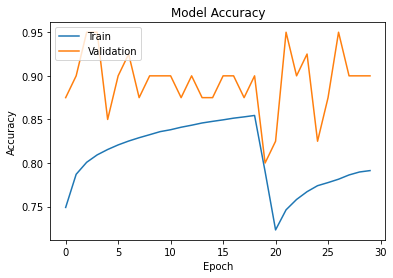

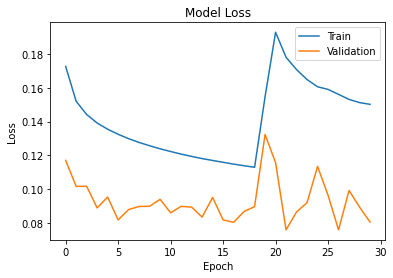

In [25]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [28]:
malstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 105)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 105)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 105, 384)     310494720   ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 50)           87000       ['embedding_2[0][0]',      